# 导言

在放松管制的能源市场中，电价对供需失衡、燃料成本和输电限制等实时因素高度敏感。虽然放松管制促进了竞争和消费者选择，但它也带来了由可变可再生能源发电、负载波动和供应链中断驱动的显著价格波动。这种波动性使成本预测复杂化，并给企业带来了运营和财务挑战，因为电力必须在发电时消耗，在平衡电网时几乎没有犯错的余地。因此，波动性会影响采购、预算和投资决策，通常会导致最终用户的成本增加。这些动态凸显了对稳健的风险管理和预测策略的需求，以应对市场的不确定性并稳定能源支出。

为了缓解放松管制的能源市场中价格波动和运营不确定性带来的挑战，先进的预测技术发挥着至关重要的作用。对电价、需求负荷和可再生能源发电的准确预测使市场参与者能够预测短期波动并相应地调整策略。通过利用数据驱动模型和机器学习算法，能源供应商和大型消费者可以优化采购计划，采用更有效的对冲策略，并提高预算准确性。例如，短期负荷预测支持电网稳定性和高效调度，而价格预测有助于评估合同机会和市场参与决策。最终，强大的预测能力增强了驾驭动态能源市场的能力，降低了财务风险，并在不确定条件下支持长期规划。

在电力市场高度波动的背景下，准确的预测模型对于管理风险和支持明智的决策至关重要。长短期记忆（LSTM）网络是一类递归神经网络（RNN），在建模能源时间序列数据中的复杂时间依赖关系方面表现出了很强的性能，如电价和负荷需求。为了更好地捕捉这些预测中固有的不确定性和不对称性，特别是在放松管制的市场条件下，可以使用弹球损失函数对LSTM模型进行优化。与专注于点估计的传统损失函数不同，弹球损失使模型能够执行分位数回归，提供概率预测，这对风险意识规划和运营策略特别有价值。这种组合使利益相关者能够预测一系列可能的结果，而不是单一的预期值，使其非常适合市场条件动态和不确定的能源应用。
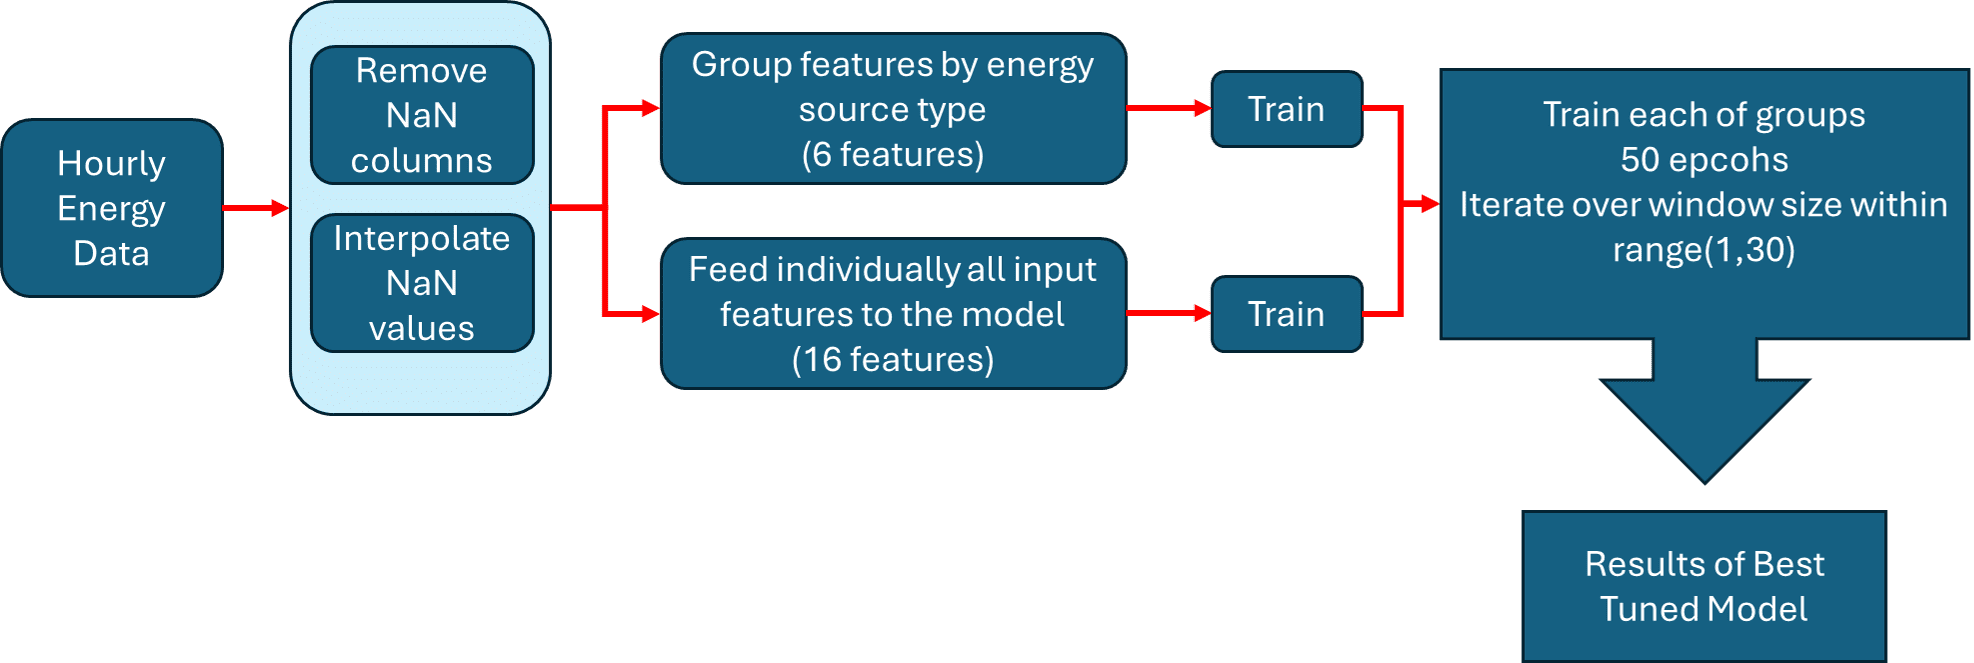

## 项目描述

在这本笔记本中，使用了一个包含各种能源每小时发电量和西班牙相应需求的数据集来训练LSTM模型。该模型的目标是基于该能源数据集预测日前电力市场价格。培训采用了两种不同的方法：第一种方法是将所有能源直接输入模型；在第二种方法中，资源按类型（化石、可再生或其他）分组。对于每种方法，模型都经过了50个迭代周期的训练，迭代了不同的窗口大小。选择模型显示最佳性能的窗口大小来展示结果。总之，本笔记本遵循下图所示的工作流程。

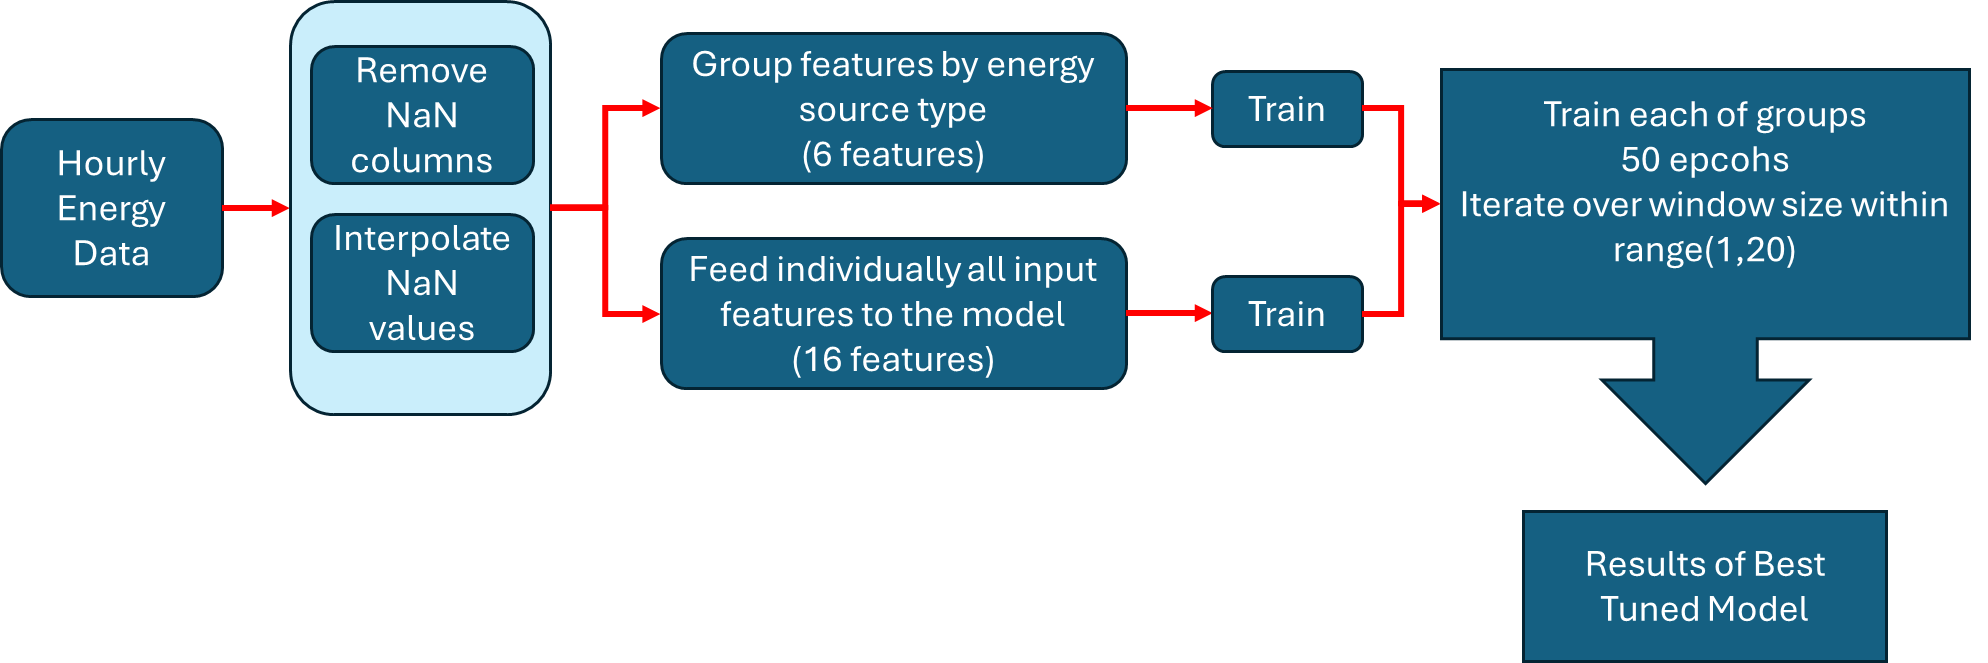
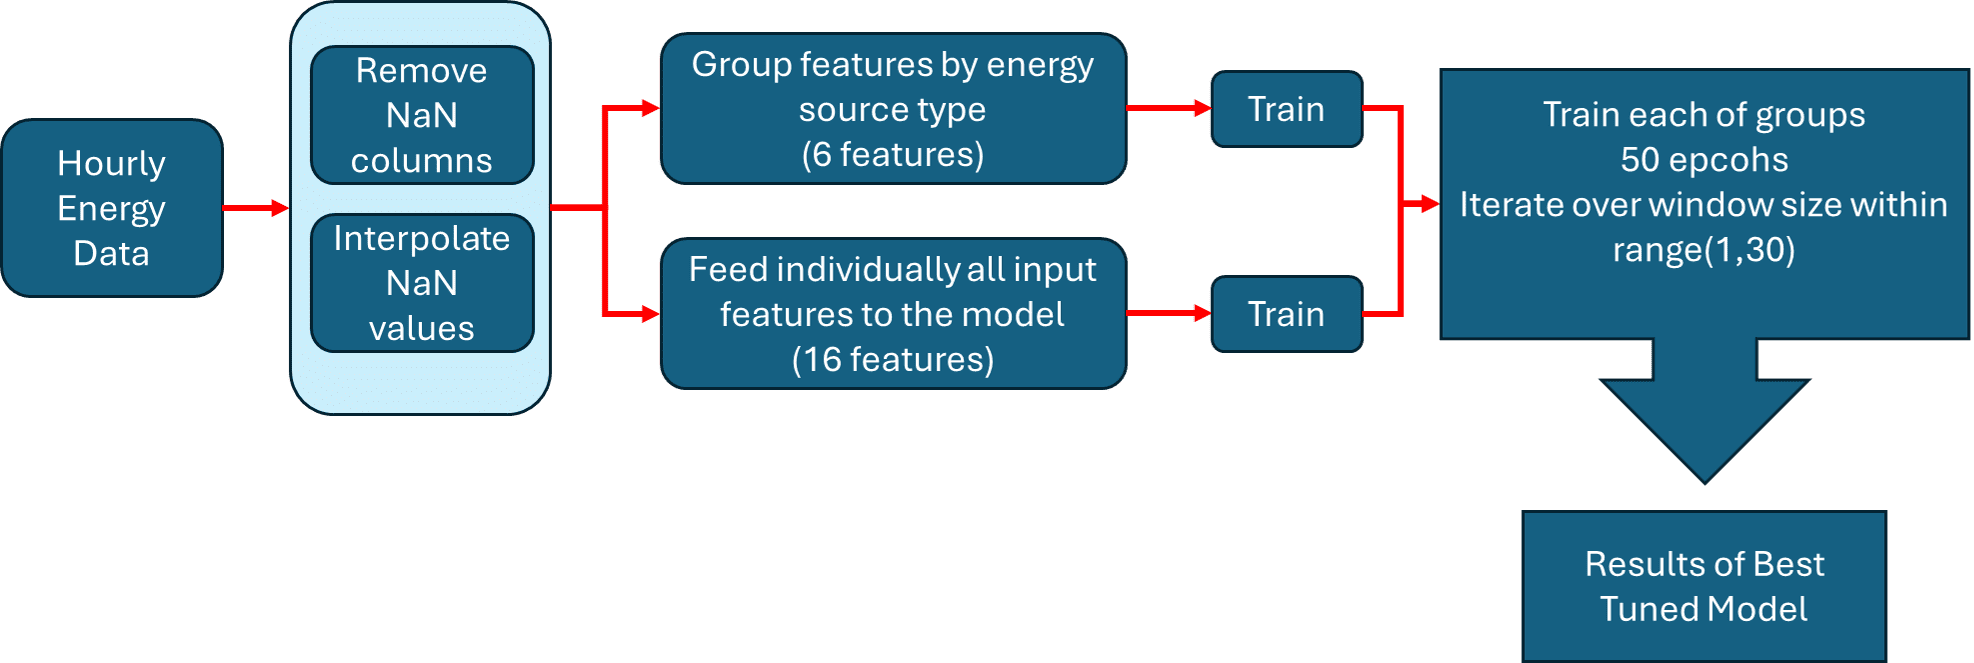

# Data Preprocesssing and Visualization

In this part, all of the necessary libraries are imported. Moreover, several functions are defined for dataset visualizatio and preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt


In [ ]:
##### This is a color class for changing printed results texts
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


##### This function generates distribution plot based on temporal value
def dist_plot(df,temporal_value):
    """
    Purpose:
    Generates distribution (box) plots of all columns in the dataframe against a specified temporal component (hour, day, month, or year).
    
    Notes:
    - Temporally enhances the dataframe with a new column based on the index (which should be datetime).
    - Uses Seaborn to plot boxplots for each feature against the specified time unit.
    - Skips the last column (df.columns[:-1]) which is assumed as the target column.
    - Useful for spotting temporal variation in features.
    """
    if temporal_value == 'hour':
        df = df.assign(hour=df.index.hour)
    elif temporal_value == 'day':
        df = df.assign(day=df.index.day)
    elif temporal_value == 'month':
        df = df.assign(month=df.index.month)
    elif temporal_value == 'year':
        df = df.assign(year=df.index.year)
    
    sns.set_theme(style="ticks", palette="pastel")
    plt.figure(figsize=(15,35))
    for i, col in enumerate(df.columns[:-1],start=1):
        plt.subplot(9,3,i)
        sns.boxplot(x=temporal_value, y=col,data=df)
        sns.despine(offset=10, trim=True)
        plt.title(f'col: {col}')
        plt.tight_layout()
    plt.show()


##### This function generates autocorrelation plots
def acf_pacf_plot(df,lags=35,iter_cols=['price actual']):
    """
    Purpose:
    Generates Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for time series analysis.

    Notes:
    - Aggregates data daily using the day of the year, then averages.
    - Plots are created for each column specified in iter_cols.
    - Helpful in determining lag dependencies for time series modeling.
    - This plot will show the window size range for iteration in training LSTM model
    """
    df = df.assign(day=df.index.dayofyear).groupby(by=['day']).mean()
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    for col in iter_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f'ACF and PACF for {col}', fontsize=16)
    
        plot_acf(df[col], ax=axes[0], lags=lags)
        axes[0].set_title('Autocorrelation')
    
        plot_pacf(df[col], ax=axes[1], lags=lags, method='ywm')  # 'ywm' is more stable for PACF
    
        plt.tight_layout()
        plt.show()

##### Generate Average Values from the dataset
def average_df(df, temporal_value, leap_year=False):
    """
    Compute average values of a DataFrame grouped by a temporal feature,
    including an option to compute a synthetic year by averaging across multiple years.

    Parameters:
    - df: pandas DataFrame with a DateTimeIndex and numeric columns
    - temporal_value: one of ['hour', 'day', 'month', 'year', 'dayofyear', 'dayofweek', 'synthetic_year']
    - leap_year: (bool) whether to include Feb 29 in synthetic_year averaging

    Returns:
    - DataFrame of averaged values by the selected temporal feature
    """

    valid_temporal_attrs = {
        'hour': 'hour',
        'day': 'day',
        'month': 'month',
        'year': 'year',
        'dayofyear': 'dayofyear',
        'dayofweek': 'dayofweek'
    }

    df = df.copy()
    df.index = pd.to_datetime(df.index)

    if temporal_value == 'synthetic_year':
        # Drop Feb 29 if not needed
        if not leap_year:
            df = df[~((df.index.month == 2) & (df.index.day == 29))]

        df['month'] = df.index.month
        df['day'] = df.index.day
        df['hour'] = df.index.hour

        group_cols = ['month', 'day', 'hour']
        average = df.groupby(group_cols).mean(numeric_only=True).reset_index()
        average = average.sort_values(by=group_cols).reset_index(drop=True)
        return average

    elif temporal_value in valid_temporal_attrs:
        attr = valid_temporal_attrs[temporal_value]
        average = df.assign(**{attr: getattr(df.index, attr)}).groupby(attr).mean(numeric_only=True)
        return average

    else:
        raise ValueError(f"Invalid temporal_value '{temporal_value}'. "
                         f"Choose from: {', '.join(list(valid_temporal_attrs.keys()) + ['synthetic_year'])}")


##### Returns correlation matrix of the dataset based on its temporal average values
def corr_matrix(df, temporal_value):
    """
    Purpose:
    Returns a correlation matrix of temporally averaged features.

    Notes:
    - Uses an average_df function to average the dataframe based on temporal_value.
    - Styled with a heatmap gradient using the 'coolwarm' color map.
    - Good for identifying relationships between features over time.
    """
    corr = average_df(df, temporal_value).corr()
    
    return corr.style.background_gradient(cmap='coolwarm')


##### Generate Twin plot for timeseries illustration of two variables in the dataset for a random date in each of four available years
def twin_plt(df, feature='gen_load_diff', num_day_range=5):
    """
    Purpose:
    Generates twin-axis time series plots to compare a selected feature against actual price, for random dates across different years.

    Notes:
    - Randomly selects a valid day and month in each of four different years.
    - Twin plots show feature on one axis and price actual on the other.
    - Includes safeguards against invalid dates (e.g., Feb 30).
    - Useful for visual correlation inspection between energy imbalance and price over short periods.
    """
    # Prepare the 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # so we can index them easily like axes[0], axes[1], ...
    
    for i, year in enumerate(df.index.year.unique()[1:4+1]):  # limit to 4 years
        rand_month = random.choice(list(df.index.month.unique()), size=1).item()
        rand_day = random.choice(list(df[df.index.month==rand_month].index.day.unique()), size=1).item()
        while (rand_month == 12) & (rand_day >= 31-num_day_range):
            rand_day = random.choice(list(df.index.day.unique()), size=1).item()
        
        try:
            start_date = pd.Timestamp(year=year, month=rand_month, day=rand_day, tz='UTC')
            end_date = start_date + pd.DateOffset(days=5)
        except ValueError:
            print(':::date is invalid:::')
            print(f"feature: {feature}; start: {year}-{rand_month}-{rand_day}")
            continue  # skip if the date is invalid (like Feb 30)

        
        df_filt_plt = df.loc[start_date:end_date]
    
        if df.empty:
            continue
    
        ax1 = axes[i]
        ax1.set_title(f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
        if (i in [2,3]):
            ax1.set_xlabel('time')
        if i in [0,2]:
            ax1.set_ylabel(feature, color='tab:red')
        ax1.plot(df_filt_plt.index, df_filt_plt[feature], color='tab:red')
        ax1.tick_params(axis='x', rotation=35)
    
        ax2 = ax1.twinx()
        if i in [1,3]:
            ax2.set_ylabel('price actual', color='tab:blue')
        ax2.plot(df_filt_plt.index, df_filt_plt['price actual'], color='tab:blue')
    
    # Layout adjustment
    plt.tight_layout()
    plt.show()


##### Import and preporcess the energy_dataset.csv dataset
def preprocessing_df_energy():
    """
    Purpose:
    Loads, cleans, and engineers features from the energy dataset (energy_dataset.csv).

    Notes:
    - Converts the time column to datetime and sets it as the index.
    - Drops columns with all missing or zero values.
    - Creates a new feature pump_storage and calculates generation-load difference (gen_load_diff).
    - Separates and aggregates fossil, renewable, and other source contributions.
    - Constructs df_energy_average_source to track grouped contributions.
    - Filters out uninformative columns, preparing df_energy for modeling.
    """
    df_energy  = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')
    # Ensuring the correct datetime format for df_energy
    df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
    # These columns are complete missing values
    df_energy.drop(columns=['generation hydro pumped storage aggregated' , 'forecast wind offshore eday ahead'],inplace=True)
    # Reset index name the same as df_weather
    df_energy.set_index('time',inplace=True)

    # interpolate remaining missing values
    df_energy = df_energy.interpolate(); df_energy.isnull().sum()

    # Combine hydro-pumped storage consumption and generation
    pump_storage = (df_energy['generation hydro pumped storage consumption'] - df_energy['generation hydro water reservoir'])
    df_energy['pump_storage'] = pump_storage
    df_energy.drop(columns=['generation hydro pumped storage consumption', 'generation hydro water reservoir'],inplace=True)


    # Some columns in df_energy are completely zero values
    zero_std_columns = df_energy.describe().loc['std'][df_energy.describe().loc['std']==0].index
    print("The following energy resources doesn't contribute to the total energy generation")
    charreg = (max([len(a) for a in zero_std_columns])-len('Column')-1)
    print("Column:",charreg*" ","Unique values")
    for col in (zero_std_columns):
        charreg =  (max([len(a) for a in zero_std_columns])-len(col))+ int(len("Unique values")/2)
        print(col,charreg*" ",df_energy[col].unique())

    forecast_cols = ['forecast solar day ahead','forecast wind onshore day ahead','total load forecast','price day ahead']
    # TSO forecast values for price and load
    df_TSOforecast = df_energy[forecast_cols].copy()

    # delete columns that are not showing any variation (zero values)
    deleted_cols_df_energy = np.append(np.array(zero_std_columns),df_energy.columns[df_energy.columns.str.contains('forecast')])
    df_energy.drop(columns=deleted_cols_df_energy,inplace=True)

    # filter column names for further processing (based on energy source type, target parameters, forecasted values)
    fossil_cols = list(df_energy.columns[df_energy.columns.str.contains('fossil')])
    renewable_cols = list(np.append(df_energy.columns[df_energy.columns.str.contains('fossil|load|price|generation other|nuclear')==False],'generation other renewable'))
    other_sources =list(df_energy.columns[df_energy.columns.str.contains('other|nuclear')].drop('generation other renewable'))
    ending_cols = list(df_energy.columns[df_energy.columns.str.contains('load|price')].drop('price day ahead'))
    
    # final df_energy for training    
    df_energy = df_energy[list(dict.fromkeys(fossil_cols + renewable_cols + other_sources+ ending_cols))]

    # Add load - generation differences per timesteps
    generation_cols = list(dict.fromkeys(fossil_cols + renewable_cols + other_sources))
    df_energy.insert(len(df_energy.columns)-1,'gen_load_diff' ,np.sum(df_energy[generation_cols],axis=1)-df_energy['total load actual'])


    # average values based on each sources
    df_energy_average_source = pd.DataFrame({
        'fossil': np.sum(df_energy[fossil_cols], axis=1),
        'renewable': np.sum(df_energy[renewable_cols], axis=1),
        'other_sources': np.sum(df_energy[other_sources], axis=1),
        'total load actual':(df_energy['total load actual']),
        'gen_load_diff':df_energy['gen_load_diff'],
        'price actual':(df_energy['price actual'])
    })
    
    return df_energy, df_energy_average_source, df_TSOforecast

In [ ]:
df_energy, df_energy_average_source, df_TSOforecast = preprocessing_df_energy()

In [ ]:
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# ***注意：你只需要在这里修改地址就可以了***
font_dir = '/kaggle/input/times-new-roman-font-dataset/Times New Roman/times new roman italic.ttf'
font_prop = FontProperties(fname=font_dir)
 
# Find the font path and add it to the font manager
font_path = fm.findfont(font_prop)
fm.fontManager.addfont(font_path)
 
# Set matplotlib rcParams to use the font family
plt.rcParams['font.family'] = font_prop.get_name()

In [ ]:
dist_plot(df_energy, temporal_value='month')

In [ ]:
corr_matrix(df_energy_average_source, temporal_value='synthetic_year')

In [ ]:
acf_pacf_plot(df_energy)

## Preparing Dataset for Training

In this part, the libraries and functions for loading and training a dataset are imported and defined.

In [ ]:
# Import Necessary Libraries
import time
import torch
import torch.nn as nn
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Generating input x and y values based on input dataframe and window size
def df_to_X_y(df,window_size):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df_as_np_x = scaler.fit_transform(df)
    df_as_np_y = df['price actual'].values
    
    X = []
    y = []
    for i in range(window_size,len(df_as_np_x)):
        row = [a for a in df_as_np_x[i-window_size:i]]
        X.append(row)
        label = df_as_np_y[i]
        y.append(label)
        
    return np.array(X), np.array(y)


# Window size is the number of time-step previous y-values as input features for the next time-step forecasting 
def split_train_test_PVforecast_model(df,window_size, train_size= 0.98, test_temporal_steps= 24):
    X,y = df_to_X_y(df,window_size)
    
    # Split the data
    train_size = int(len(df) * train_size)
    test_size  = test_temporal_steps
    val_size   = len(df) - train_size - test_size
    X_train, X_val, X_test = X[:train_size],X[train_size:train_size+val_size],X[-(test_size):]
    y_train, y_val, y_test = y[:train_size],y[train_size:train_size+val_size],y[-(test_size):]

    print('X_train',X_train.shape,'\n'
          'X_val  ',X_val.shape,'\n'
          'X_test ',X_test.shape,'\n'
          'y_train',y_train.shape,'\n'
          'y_val  ',y_val.shape,'\n'
          'y_test ',y_test.shape)
    
    return X_train,X_val,X_test,y_train,y_val,y_test,test_size


# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Model: LSTM

Recurrent Neural Networks (RNNs) are primarily designed to process sequential data. Their architecture includes hidden states that capture information from previous time steps. However, RNNs face significant challenges in learning long-term dependencies due to the vanishing and exploding gradient problems during training. Long Short-Term Memory (LSTM) networks are an improved variant of the RNN model, introduced by Hochreiter and Schmidhuber (1997) <a href="https://doi.org/10.1162/neco.1997.9.8.1735" target="_blank" style="font-size: 18px; font-weight: bold;">[1]</a>. The architecture incorporates a memory cell regulated by three gates: input, forget, and output gates. These gates control the flow of information, determining how much of the input, previous memory, and output should be retained or discarded at each time step. The picture below illustrates the structure of an LSTM memory cell.

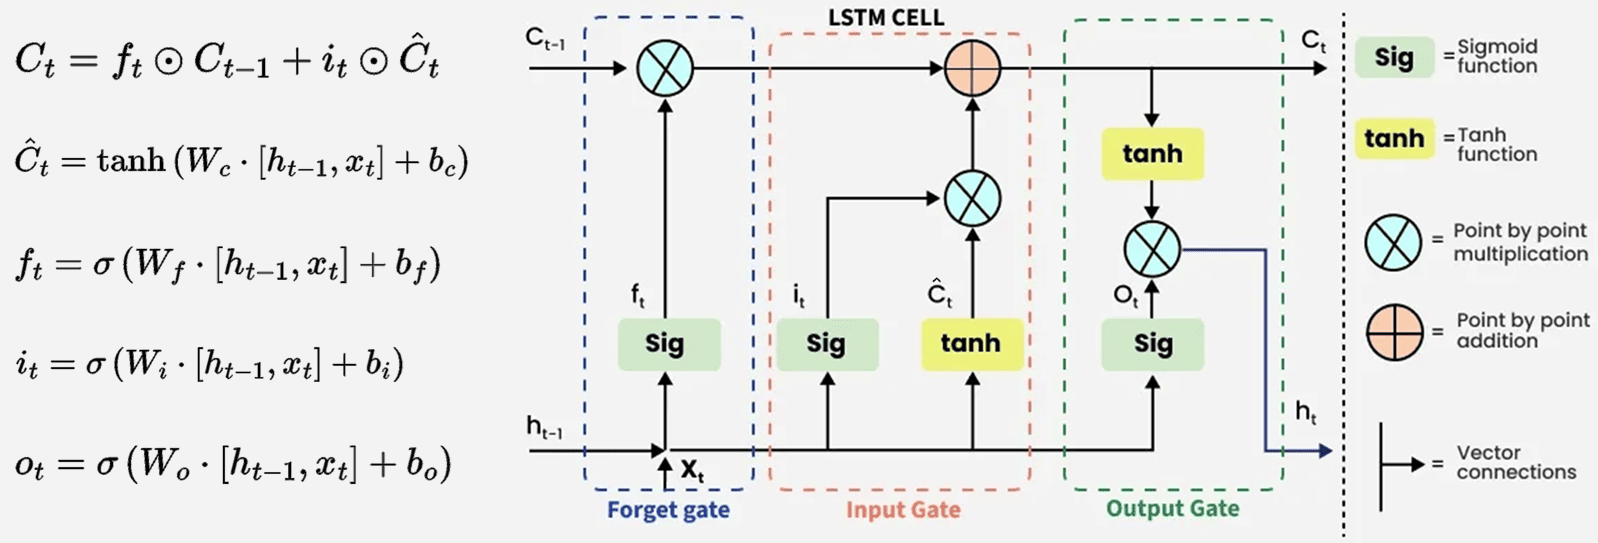


<div style="display: flex; align-items: flex-start">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20250404172507256364/forget_gate.jpg" alt="Forget Gate" style="height:250px;">
  <p>
    In the <strong>forget gate</strong>, the previous <em>cell state</em> and <em>hidden state</em> are involved in determining what information should be retained or discarded in the current LSTM cell. The <em>cell state</em> carries long-term memory, capturing essential information accumulated over all previous time steps. In contrast, the <em>hidden state</em> conveys more immediate or short-term information from the previous adjacent cell. Two inputs—<span style="font-family: monospace;">$x_t$</span> (the input at the current time step) and <span style="font-family: monospace;">$h_{t-1}$</span> (the hidden state from the previous time step)—are fed into the forget gate. These inputs are multiplied by learned weight matrices, and a bias term is added. The result is passed through a sigmoid activation function, producing an output between 0 and 1. This output acts as a gating signal. A value close to 0 means the corresponding piece of information in the cell state will be forgotten, while a value close to 1 means the information will be retained for future steps.
  </p>
</div>

<div style="height: 20px;"></div>

<div style="display: flex; align-items: flex-start;">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20250404172524079223/input_gate.jpg" alt="Input Gate" style="height: 250px;">
  <p>
    The <strong>input gate</strong> is responsible for adding new information to the cell state. First, a <em>sigmoid activation function</em> is applied to the inputs 
    <span style="font-family: monospace;">$h_{t-1}$</span> (previous hidden state) and 
    <span style="font-family: monospace;">$x_t$</span> (current input) to produce a filter that determines which values should be updated—similar to how the forget gate works. Next, a <em>candidate vector</em> is created by applying the <em>tanh activation function</em> to the same inputs. This vector contains possible new values, scaled between -1 and +1, representing potential updates to the cell state. The output of the sigmoid gate (which decides <em>what</em> to update) is then element-wise multiplied with the candidate vector (which suggests <em>how much</em> to update). This produces the new information to be added to the cell state. Finally, this new information is added to the scaled previous cell state, which was filtered by the forget gate. The result is the updated cell state, carrying both retained and newly relevant information.
  </p>
</div>

<div style="height: 20px;"></div>

<div style="display: flex; align-items: flex-start;">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20250404172543950041/output_gate.jpg" alt="Output Gate" style="height: 250px;">
  <p>
    The <strong>output gate</strong> is responsible for extracting useful information from the current cell state to produce the hidden state output. First, the cell state is passed through a <em>tanh activation function</em> to create a candidate output vector, which scales the values between -1 and +1. Then, a <em>sigmoid function</em> is applied to the inputs 
    <span style="font-family: monospace;">$h_{t-1}$</span> (previous hidden state) and 
    <span style="font-family: monospace;">$x_t$</span> (current input), producing a gating signal that determines which parts of the candidate vector should be passed on. Finally, the output of the sigmoid gate is element-wise multiplied with the tanh-transformed cell state. The result is the new hidden state <span style="font-family: monospace;">$h_t$</span>, which serves both as the output of the current LSTM cell and as input to the next cell in the sequence.
  </p>
</div>

In [ ]:
class QuantileLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, quantiles=[0.1, 0.5, 0.9]):
        super(QuantileLSTMModel, self).__init__()
        self.quantiles = quantiles
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, len(quantiles))  # Output one value per quantile

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out  # shape: (batch_size, num_quantiles)

##  Pinball Loss

Pinball loss measures the accuracy of quantile predictions. Instead of just forecasting a single value (like average wind power), a model can predict different quantiles (e.g., 10th, 50th, 90th percentiles) — which gives more information about uncertainty and distribution of possible outcomes.

The formula for pinball loss at quantile $q$ is:



Where:

$\hat{y}$ is the predicted quantile value 

$y$ is the actual observed value

$q$ is the quantile (e.g., 0.9 for the 90th percentile). It is is a value that divides a given set of numbers such that $q × 100%$ of the numbers are less than or equal to this value, while the remaining $(1 − q) × 100%$ of the numbers are greater than or equal to this value. The table below illustrates the applications of different quantile values.

$L_q(\hat{y}, y)= \begin{cases}q \cdot(y-\hat{y}) & \text { if } y>\hat{y} \\ (1-q) \cdot(\hat{y}-y) & \text { otherwise }\end{cases}$


For detailed information about the application of Pinball loss and quantile regression in energy price forecasting, you can read my another notebook in https://www.kaggle.com/code/aliakbaryaghoubi/uncertainty-in-forecasting-pinball-loss.

In [ ]:
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        loss = torch.max((q - 1) * errors, q * errors)
        losses.append(torch.mean(loss))
    return torch.mean(torch.stack(losses))  # Mean over quantiles


# Train

The model is now trained via the following function. The criterion for optimization is pinball loss. Also, the common metrics such as $MAE$, $RMSE$ , and $R^2$ will also be presented.

In [ ]:
def train_quantile_model(model, train_loader, val_loader, test_loader,
                         quantiles=[0.05, 0.5, 0.95],
                         num_epochs=50, patience=5, checkpoint_path='best_quantile_model.pth', optimum_window_size_search=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print(f"Using device: {torch.cuda.get_device_name()}")
    else:
        print(f"device uses {device}")
    model = model.to(device)

    criterion = lambda preds, target: quantile_loss(preds, target, quantiles)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val_loss = np.inf
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_mae_list = []
    val_rmse_list = []
    val_r2_list = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        y_true, y_pred_median = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

                y_true.extend(y_batch.cpu().numpy())
                y_pred_median.extend(output[:, 1].cpu().numpy())  # median = quantile 0.5

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)

        mae = mean_absolute_error(y_true, y_pred_median)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_median))
        r2 = r2_score(y_true, y_pred_median)
        val_mae_list.append(mae)
        val_rmse_list.append(rmse)
        val_r2_list.append(r2)

        current_lr = optimizer.param_groups[0]['lr']
        duration = time.time() - start_time
        
        if optimum_window_size_search == False:
            print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.2f} | "
              f"Val Loss: {avg_val_loss:.2f} | "
              f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f} | "
              f"LR: {current_lr:.6f} | Time: {duration:.1f}s")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if optimum_window_size_search == False:
                    print("🛑 Early stopping triggered.")
                break

    # === Load best model ===
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))

    # === Test Evaluation ===
    model.eval()
    y_test_true, y_test_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            y_test_true.extend(y_batch.numpy())
            y_test_pred.extend(output.cpu().numpy())

    y_test_true = np.array(y_test_true)
    y_test_pred = np.array(y_test_pred)

    test_mae = mean_absolute_error(y_test_true, y_test_pred[:, 1])  # median
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred[:, 1]))
    test_r2 = r2_score(y_test_true, y_test_pred[:, 1])

    print(f"\n🚀 Final Test Results → MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f} | R²: {test_r2:.4f}\n\n")

    if optimum_window_size_search == False:

        # === Plotting ===
        plt.figure(figsize=(18, 5))
    
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label="Train Loss", linestyle='--')
        plt.plot(val_losses, label="Val Loss", linewidth=2)
        plt.xlabel("Epochs")
        plt.ylabel("Quantile Loss")
        plt.title("Loss Curve")
        plt.legend()
    
        plt.subplot(1, 3, 2)
        plt.plot(val_mae_list, label="Val MAE", color='green')
        plt.plot(val_rmse_list, label="Val RMSE", color='orange')
        plt.xlabel("Epochs")
        plt.title("MAE & RMSE over Epochs")
        plt.legend()
    
        plt.subplot(1, 3, 3)
        plt.plot(val_r2_list, label="Val R²", color='purple')
        plt.xlabel("Epochs")
        plt.title("R² Score over Epochs")
        plt.ylim(0,1)
        plt.legend()
    
        plt.tight_layout()
        plt.show()
    
        # === Forecast Visualization with Quantile Range ===
        plt.figure(figsize=(20, 6))
        prev_days_plt = 3
    
        dt_plot = (df_energy['price actual'].tail(prev_days_plt*len(y_test)).index.values)
        plt.plot(dt_plot, df_energy['price actual'].tail(prev_days_plt*24).values, label='Ground Truth', color='black')
        
        dt_plot = (df_energy['price actual'].tail(len(y_test)).index.values)
        plt.plot(dt_plot, y_test_pred[:, 2], label='Upper bound Forecast (q > 0.5)', linewidth=3, linestyle='dotted', color='orange')
        plt.plot(dt_plot, y_test_pred[:, 1], label='Median Forecast          (q = 0.5)', linewidth=3, linestyle='dashed', color='green')
        plt.plot(dt_plot, y_test_pred[:, 0], label='Lower bound Forecast (q < 0.5)' ,linewidth=3, linestyle='dotted', color='red')
        
        plt.fill_between(dt_plot,
                         y_test_pred[:, 0], y_test_pred[:, 2],
                         alpha=0.3, label=f'Quantile Interval: [{quantiles[0]}–{quantiles[-1]}]', color='skyblue')
        plt.legend()
        plt.title("Quantile Forecast for 24 hours ahead")
        plt.xlabel("Datetime")
        plt.ylabel("Energy Price")
        plt.savefig("Forecast_plot.png")
        plt.show()

    return (model, [test_mae, test_rmse, test_r2]) if optimum_window_size_search else model

## Iterate Over Different Window Sizes

In [ ]:
def best_model(best_model_info):
    
    target_name   = best_model_info[0]
    opt_wind_size = best_model_info[1]
    for name, df in datasets:
        if name == target_name:
            return df, opt_wind_size
    raise ValueError(f"No DataFrame found with name '{target_name}'")

In [ ]:
quantiles = [0.1, 0.5, 0.90]

# Saving Results in a DataFrame
Results_iter_window_size = pd.DataFrame(
    columns=["MAE", "RMSE", "R²"],
    index=pd.MultiIndex.from_tuples([], names=["feature_set", "window_size"])
)

# Pair DataFrames with names
datasets = [
    ('all_features', df_energy.copy()),
    ('average_features', df_energy_average_source.copy())
]

# Iterate over two dataframes(average and individuals) to find the best window size and data frame for training.
for name, df in datasets:
    for window_size in range(1, 20+1):
        
        print(color.BOLD + color.RED + "feature_set:" + color.END + color.BOLD, name, color.RED + " window size:" + color.END + color.BOLD, window_size, color.END)

        # Data Input based on the window size
        X_train, X_val, X_test, y_train, y_val, y_test, test_size = split_train_test_PVforecast_model(df, window_size=window_size)

        # Load the input data on PyTorch DataLoader
        train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
        val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=64, shuffle=False)
        test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

        # Process the model and Saving the Results
        model = QuantileLSTMModel(input_size=len(df.columns), quantiles=quantiles)
        _, Results_iter_window_size.loc[(name, window_size), ["MAE", "RMSE", "R²"]] = train_quantile_model(
            model, train_loader, val_loader, test_loader, num_epochs=20,
            quantiles=quantiles, optimum_window_size_search=True
        )

In [ ]:
# Plot the Results
plt.figure(figsize=(20,8))
for name, _ in datasets:    
    for i, col in enumerate(Results_iter_window_size.columns, start=1):
        plt.subplot(1, 3, i)
        if name =="all_features":
            plt.plot(Results_iter_window_size.loc[name,col], color='Blue', label = name)
        else:
            plt.plot(Results_iter_window_size.loc[name,col], linestyle = 'dashed' ,color='Blue', label=name)
            
        plt.legend()
        plt.xlabel('Window Size')
        plt.title(f'{col}')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # forces integer x-axis
plt.show()
print(f"""\nThe Best Window Size:
MAE:  {min(Results_iter_window_size['MAE']):.4f}    in (feature_set, window_size) = {Results_iter_window_size[Results_iter_window_size['MAE']==min(Results_iter_window_size['MAE'])].index.values[0]}
RMSE: {min(Results_iter_window_size['RMSE']):.4f}   in (feature_set, window_size) = {Results_iter_window_size[Results_iter_window_size['RMSE']==min(Results_iter_window_size['RMSE'])].index.values[0]}
R²:   {max(Results_iter_window_size['R²']):.4f}   in (feature_set, window_size) = {Results_iter_window_size[Results_iter_window_size['R²']==max(Results_iter_window_size['R²'])].index.values[0]}""")

best_model_info = Results_iter_window_size[Results_iter_window_size['R²']==max(Results_iter_window_size['R²'])].index.values[0]

## Represent the Results of the Best Tuned Model

In [ ]:
df, opt_window_size = best_model(best_model_info)

X_train, X_val, X_test, y_train, y_val, y_test, test_size = split_train_test_PVforecast_model(df,window_size=opt_window_size)

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

quantiles = [0.1, 0.5, 0.90]
model = QuantileLSTMModel(input_size=len(df.columns), quantiles=quantiles)
trained_model = train_quantile_model(model, train_loader, val_loader, test_loader, num_epochs=50, quantiles=quantiles)